In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import pickle

In [4]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mn = 0.602 # mass of N in lattice unit
mpi = 510/ainv # mass of pion in lattice unit

In [5]:
from scipy.sparse.linalg import LinearOperator

# import R-correlator

In [6]:
with open('../data/Rcorr_jk_1s0_nn_L48.pkl', 'rb') as fin:
    _, rs, Rcorr_jk = pickle.load(fin)

In [7]:
its = Rcorr_jk['wall'].keys()

In [8]:
its

dict_keys([10, 11, 12, 13, 14, 15, 16, 17])

In [9]:
bin_num = Rcorr_jk['wall'][10].shape[0]

# decompress wave function

In [10]:
L = 48
rs_full = np.array([np.sqrt(ix**2 + iy**2 + iz**2)
                    for ix in range(-L//2,L//2)
                    for iy in range(-L//2,L//2)
                    for iz in range(-L//2,L//2)]).reshape(L,L,L)
rs_full = np.roll(rs_full, (L//2,L//2,L//2), axis=(0,1,2)).flatten()


In [11]:
a1_uniq = np.array([ix + L * (iy + L * iz)
                   for ix in range(0, L//2+1)
                   for iy in range(0, ix+1)
                   for iz in range(0, iy+1)])

In [12]:
a1_uniq_ind = {}
ind = 0
for ix in range(0, L//2+1):
    for iy in range(0, ix+1):
        for iz in range(0, iy+1):
            a1_uniq_ind[(ix, iy, iz)] = ind
            ind += 1
xyz_ind = {}
for ix in range(L):
    for iy in range(L):
        for iz in range(L):
            _ind = np.sort([min(ix,L-ix), min(iy,L-iy), min(iz,L-iz)])[::-1]
            xyz_ind[(ix,iy,iz)] = a1_uniq_ind[(_ind[0], _ind[1], _ind[2])]

In [13]:
Rcorr_jk_full = {}
for src in ['wall', 'exp']:
    Rcorr_jk_full[src] = {}
    for it in its:
        wave_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    wave_full[:,ix,iy,iz] = Rcorr_jk[src][it][:,xyz_ind[(ix,iy,iz)]]
        Rcorr_jk_full[src][it] = wave_full.reshape(bin_num, L**3)

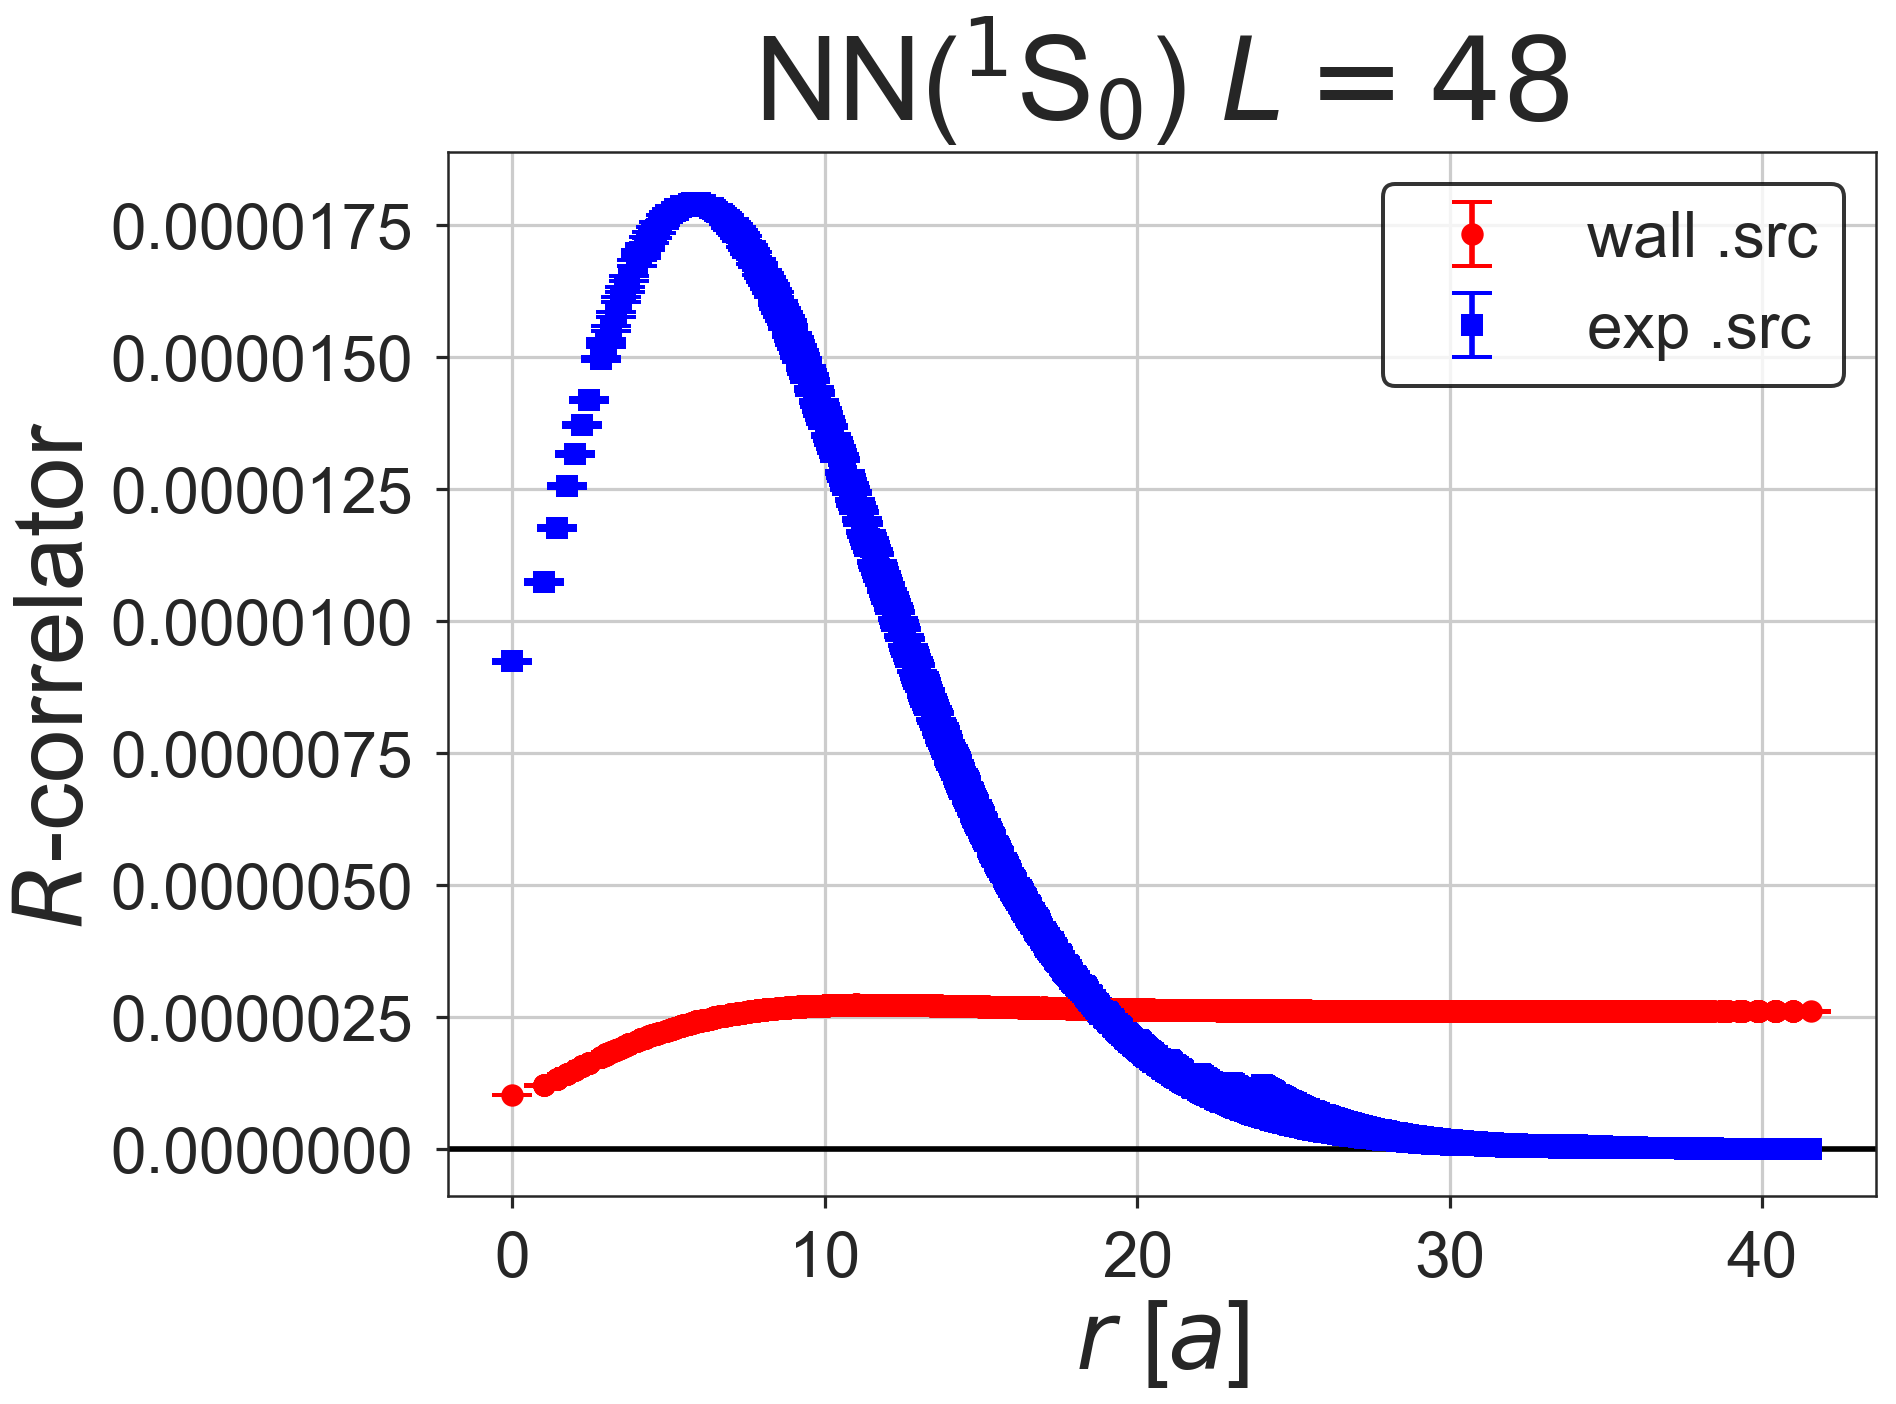

In [14]:
fig, ax = plt.subplots()

it0 = 12
for src, fmt, col in zip(['wall', 'exp'], ['o', 's'], ['red', 'blue']):
    ax.errorbar(rs_full, Rcorr_jk_full[src][it0].mean(axis=0),
           Rcorr_jk_full[src][it0].std(axis=0) * np.sqrt(bin_num), fmt=fmt,
                label=src + ' .src', color=col, capthick=2.0, capsize=10)
    
ax.set_xlabel(r'$r$ [$a$]', size=48)
ax.set_ylabel(r'$R$-correlator', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.axhline(0, color='black')
ax.set_title(r'NN($^1$S$_0$) $L = 48$', size=58, y=1.02);

# potential

In [15]:
lap = lambda vec: - 6.0 * vec + (  np.roll(vec,+1,0) + np.roll(vec,-1,0)
                                 + np.roll(vec,+1,1) + np.roll(vec,-1,1)
                                 + np.roll(vec,+1,2) + np.roll(vec,-1,2))
def A1_proj(wave_in):
    wave_tmp0 = wave_in
    wave_tmp1 = (wave_tmp0[:,:,:] + np.roll(wave_tmp0,-1,0)[::-1,:,:]
                + np.roll(wave_tmp0,-1,1)[:,::-1,:]
                + np.roll(wave_tmp0,-1,2)[:,:,::-1]
                + np.roll(np.roll(wave_tmp0,-1,0),-1,1)[::-1,::-1,:]
                + np.roll(np.roll(wave_tmp0,-1,1),-1,2)[:,::-1,::-1]
                + np.roll(np.roll(wave_tmp0,-1,2),-1,0)[::-1,:,::-1]
                + np.roll(np.roll(np.roll(wave_tmp0,-1,0),-1,1),-1,2)[::-1,::-1,::-1])/8.0
    wave_tmp2 = (wave_tmp1 
                + np.swapaxes(wave_tmp1,0,1)
                + np.swapaxes(wave_tmp1,1,2)
                + np.swapaxes(wave_tmp1,2,0)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,1),1,2)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,2),2,1))/6.0e0

    return wave_tmp2

In [16]:
Rcorr_jk_full['wall'][12].shape

(20, 110592)

In [17]:
mn*ainv

1320.788

In [18]:
m_red = 0.5 * mn # reduced mass

In [19]:
pot_jks = {}
for src in ['wall', 'exp']:
    for it0 in [12, 13, 14]:
        pot_jk = {}
        _rcorr = Rcorr_jk_full[src][it0].reshape(bin_num, L, L, L)
        _rcorr_tp = Rcorr_jk_full[src][it0+1].reshape(bin_num, L, L, L)
        _rcorr_tn = Rcorr_jk_full[src][it0-1].reshape(bin_num, L, L, L)

        pot_jk['lap'] = np.array([lap(_rcorr[ibin,:,:,:])/_rcorr[ibin,:,:,:]/(2.0*m_red)
                                 for ibin in range(bin_num)]).reshape(bin_num, L**3)
        pot_jk['dt'] = np.array([ - (_rcorr_tp[ibin,:,:,:] - _rcorr_tn[ibin,:,:,:])/(2.0*_rcorr[ibin,:,:,:]) 
                                for ibin in range(bin_num)]).reshape(bin_num, L**3)
        pot_jk['dt2'] = np.array([ (_rcorr_tp[ibin,:,:,:] - 2*_rcorr[ibin,:,:,:] + _rcorr_tn[ibin,:,:,:])/(_rcorr[ibin,:,:,:])/(8.0*m_red) 
                                 for ibin in range(bin_num)]).reshape(bin_num, L**3)

        pot_jk['tot'] = pot_jk['lap'] + pot_jk['dt'] + pot_jk['dt2']

        pot_jks[(src, it0)] = pot_jk


Text(0,0.5,'$V_0^\\mathrm{LO}(r)$ [MeV]')

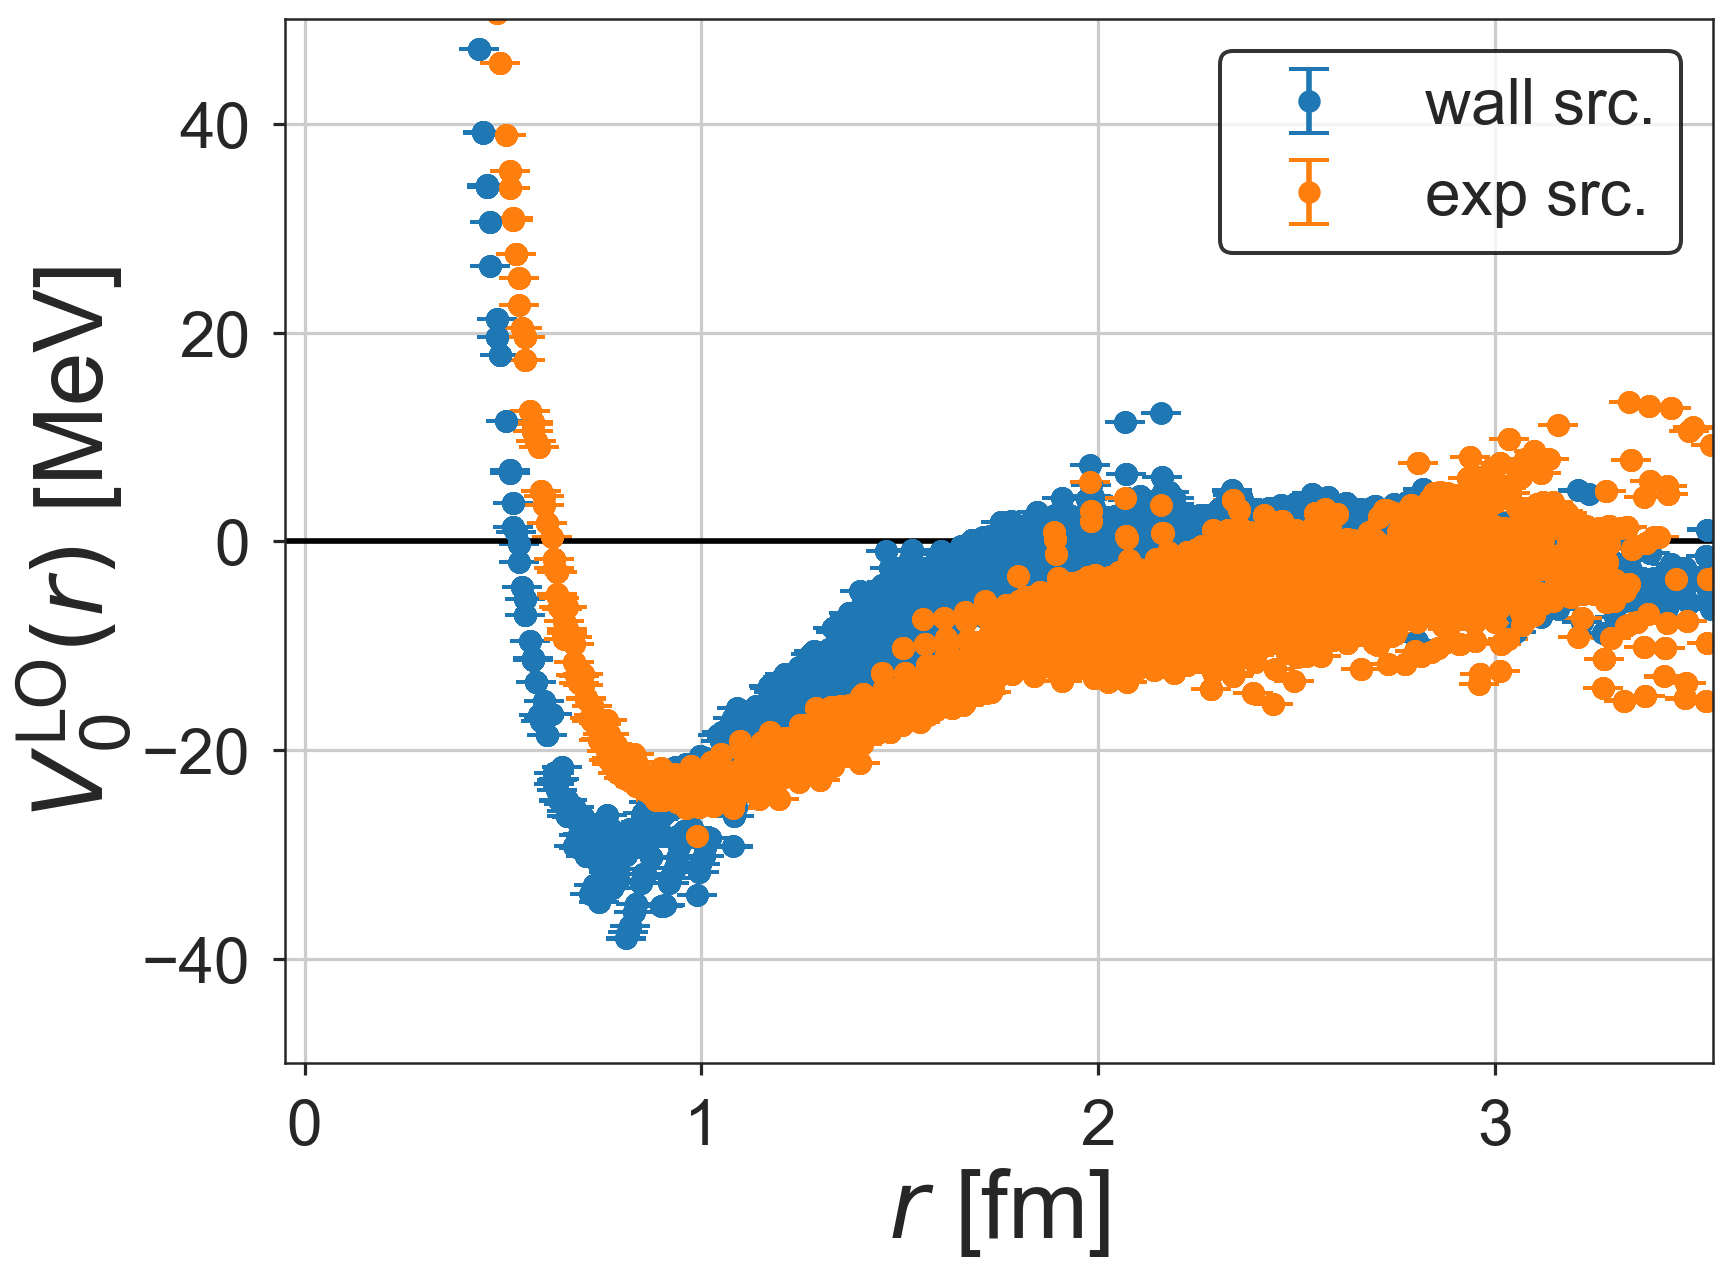

In [20]:
fig, ax = plt.subplots()
it0 = 12
for src in ['wall', 'exp']:
    pot = pot_jks[(src, it0)]['tot']
    ax.errorbar(rs_full*lat_unit,
               pot.mean(axis=0)*ainv, pot.std(axis=0)*np.sqrt(bin_num - 1),
               fmt='o', capthick=2.0, capsize=10,
               label=src + ' src.')
    
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_xlim(-0.05, 3.55)
ax.set_ylim(-50, 50)
ax.axhline(0, color='black')
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_0^\mathrm{LO}(r)$ [MeV]', size=48)

# eigensolver

In [21]:
scipy.sparse.linalg.eigsh?

In [22]:
Vol = L**3
it0 = 12
Nev = 5 # low-lying 5 modes
pot = pot_jks[('wall', it0)]['tot']

eigen_val = []
eigen_vec = []
for ibin in range(bin_num):
    print('# {}'.format(ibin))
    H = LinearOperator((Vol, Vol),
                         matvec= lambda vec: pot[ibin,:] * vec
                         - lap(vec.reshape(L,L,L)).flatten()/(2.0*m_red))

    vals, vecs = scipy.sparse.linalg.eigsh(H, which='SM', k=Nev)
    flag = [] # A1 state
    
    for index, ival in enumerate(vals):
        vecs[:,index] *= np.sign(vecs[0,index])
        wave_a1_proj = A1_proj(vecs[:,index].reshape(L,L,L))
        a1norm = np.sum(wave_a1_proj*wave_a1_proj)
        if np.abs(a1norm) >= 0.99:
            print(index, ival*ainv, a1norm)
            flag.append(True)
        else:
            flag.append(False) 
            
    eigen_val.append(vals[flag])
    eigen_vec.append(vecs[:,flag])
    
eigen_val = np.array(eigen_val)
eigen_vec = np.array(eigen_vec)

# 0
0 -3.3154866338230016 0.9999999999999915
4 58.446385220603155 0.9999999999999915
# 1
0 -3.1917399161760773 1.0000000000000004
4 58.64312544958357 0.9999999999999911
# 2
0 -3.284308258904075 1.0000000000000016
4 58.66752443749879 0.9999999999999816
# 3
0 -3.4695347856270353 1.0000000000000044
4 58.34578131438239 0.9999999999999946
# 4
0 -3.296263378425797 1.000000000000001
4 58.74951121666893 0.9999999999999807
# 5
0 -3.4038806453051227 1.000000000000004
4 58.31413330012866 0.9999999999999927
# 6
0 -3.23285363758819 1.0000000000000118
4 58.75308671248949 0.9999999999999997
# 7
0 -3.161040854451733 1.000000000000008
4 58.73446238986783 0.9999999999999905
# 8
0 -3.090153968757215 1.000000000000001
3 58.74584320682344 0.9999999999999963
# 9
0 -3.2651187150085965 1.0000000000000102
4 58.48054461641099 0.9999999999999872
# 10
0 -3.3181989375763172 1.0000000000000013
4 58.53618078822575 1.0000000000000018
# 11
0 -3.243559503741219 0.9999999999999973
4 58.43338890867229 0.9999999999999957


In [23]:
print(vals*ainv)

[-3.19898867 58.42695397 58.43435006 58.43435006 58.43435006]
